In [1]:
import numpy as np
import matplotlib.pyplot as plt

from qiskit import IBMQ, BasicAer
from qiskit.providers.ibmq import least_busy
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, execute

from qiskit.tools.visualization import plot_histogram


# 1. Introdução
Neste trabalho, iremos implementar o algoritmo de Deutsch-Josza utilizando a biblioteca [Qiskit](https://community.qiskit.org) da IBM

# 2. Problema
O problema de Deutsch-Josza é uma generalização do problema de Deutsch, em que queremos determinar se uma função $f:\{0,1\} \rightarrow \{0,1\}$ é balanceada (imagens distintas) ou constante (imagens iguais). Neste caso, queremos determinar de uma função genérica $f:\{0,1\}^{n} \rightarrow \{0,1\}$ é balanceada ou constante. Tanto para o problema de Deutsch como para o problema de Deutsch-Josza, temos apenas dois tipos de função: constante ou balanceada. Classicamente, este problema tem complexidade $O(2^n)$ para ser resolvido, sendo $n$ o número de bits. Entretanto, quanticamente, podemos resolvê-lo em complexidade $O(1)$ sem erros.

## Algoritmo

O algoritmo de Deutsch-Josza é descrito da seguinte maneira:
1. Inicialize dois registradores: um com n-qubits inicializados em |0>, o outro com um qubit inicializdo em |1>
1. Aplique Haddamard em cada qubit
1. Aplique o oráculo |x> |y> = |x>|(y+f(x))%2>
1. Aplique Haddamard em todos os qubits do primeiro registrador
1. Faça medição na saída

# 3. Implementação
Incialmente, iremos determinar com quantos bits iremos trabalhar

In [2]:
# Trabalharemos com uma string de 4 qubits
n = 4

n

4

Em seguida, iremos determinar com qual tipo de função iremos trabalhar: constante ou balanceada

In [3]:
oracle = "b"

# se o oraculo eh balanceado, seta a string de saida
if oracle == "b":
    b = np.random.randint(1,2**n)

# se o oraculo eh constante, seta c = 0.
if oracle == "c":
    c = 0

try:
    print("Valor de b: {0:b}".format(b))
except:
    pass
try:
    print("Valor de c:",c)
except:
    pass

Valor de b: 1001


A ideia por tras é que, caso a função seja balanceada, iremos retornar o valor de b na saida (cada bit em uma das saídas. Isso ficará mais claro mais a frente). Caso contrário, iremos retornar 0 em todas as saidas.

## Construindo o Circuito
Inicialmente, iremos inicializar os registradores quânticos e clássicos. Todos os qubits iniciam com $0$, mas é necessário setar o n-ésimo qubit com $1$. Além disso, aplicamos Haddamard para todas as entradas, para obter superposição. Abaixo, implementamos precisamente isso.

In [4]:
# Criando registradores
# n qubits para oraculo e um qubit para resposta

qr = QuantumRegister(n+1)
cr = ClassicalRegister(n)

djCircuit = QuantumCircuit(qr, cr)
barriers = True

# Todos qubits sao inicializados com |0>, precisamos setar o decimo qubit para o estado |1>
djCircuit.x(qr[n])

# Aplicar barreiras
if barriers:
    djCircuit.barrier()

    
# Aplicar hadamard em todos os qubits
djCircuit.h(qr)    
    


Circuito até o momento, que corresponde aos dois primeiros passos do algoritmo:

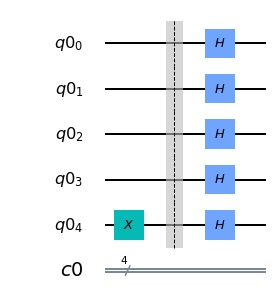

In [5]:
djCircuit.draw(output='mpl')

Abaixo, iremos implementar a parte principal do circuito que determina se a função é constante ou balanceada. Note que após aplicar a transformação, iremos aplicar Haddamard em todos os qubits de 0 a n-1. Após isso, iremos realizar as medições necessárias. Esta etapa equivale aos passos 3 a 5 do algoritmo

In [6]:
# Outra barreira
if barriers:
    djCircuit.barrier()

# Diga-me, oraculo, qual a resposta?
if oracle == "c": # "sou constante, bruno", retorna c
    if c == 1:
        djCircuit.x(qr[n])
    else:
        djCircuit.iden(qr[n])
else: # "sou balanceado, bruno" retorna o produto interno da entrada com b  
    for i in range(n):
        if (b & (1 << i)):
            djCircuit.cx(qr[i], qr[n])

# Quase la, mais uma barreira
if barriers:
    djCircuit.barrier()

# Aplicando haddamard aos registradores depois de perguntar ao oraculo
for i in range(n):
    djCircuit.h(qr[i])

# Medindo, finalmente
for i in range(n):
    djCircuit.measure(qr[i], cr[i])

Visualização do circuito em seu formato final:

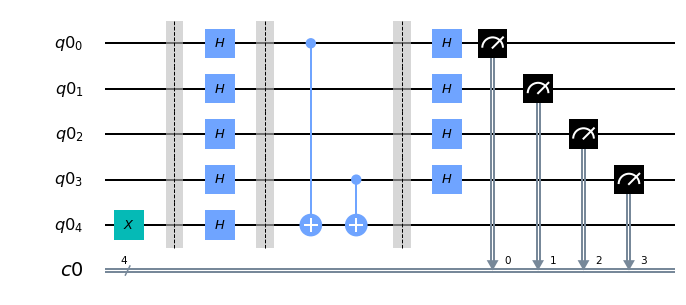

In [7]:
djCircuit.draw(output='mpl')

Por fim, iremos simular o circuito localmente. Lembrando que definimos que a saída deve ser igual ao valor de b inicializado ao começo desse notebook, caso seja balanceada, ou zero em todas as saídas, caso contrário:

In [8]:
print("Valor de b:",b)

Valor de b: 9


# 4. Simulação
Abaixo, iremos simular o circuito para conferir que a função é realmente balanceada.

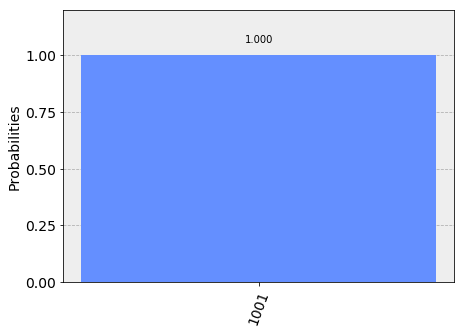

In [9]:
# Simulando localmente
backend = BasicAer.get_backend('qasm_simulator')
shots = 2048
results = execute(djCircuit, backend=backend, shots=shots).result()
answer = results.get_counts()

plot_histogram(answer)

Como é possível observar acima, obtivemos que a função é constante com 100% de prababilidade, pois a saída da simulação é precisamente o valor de b determinado, em código binário.

# Referências

1. https://community.qiskit.org/textbook/ch-algorithms/deutsch-josza.html